In [1]:
#!/home/neurone-pc1/anaconda3/envs/tagliaferri_task/bin/python
import pandas as pd

# Load count data
counts = pd.read_csv('all_counts_compared.csv', header=0)

# Print the head of the file
print(counts.head())

# Print the dimensions of the table
print(counts.shape)

# Create metadata
#metadata = pd.DataFrame({
#    'sample': counts.columns,
#    'condition': ['CD', 'CD','CD', 'NC', 'NC','NC']  # Adjust as per your data
#})

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds  import DeseqStats
#print(counts.columns)
#print("Columns are printed correctly")
#print()
counts=counts.set_index('Ensembl_ID') #error happens here, solved  with header comma separated
counts = counts[counts.sum(axis = 1)>= 10]
# "we filter out genes that have less than 10 read counts in total"
#changed to one

counts=counts.T #matrix transposition, now genes are columns, samples are rows
metadata = pd.DataFrame(zip(counts.index, ['CD','CD','CD','NC','NC','NC']),columns = ['Sample','Condition'])
metadata = metadata.set_index('Sample')
#print(metadata)

dds=DeseqDataSet(counts=counts, metadata=metadata , design_factors=  "Condition") #changed design_factors in just design
#print()
#print(dds)
#print()
#print(dds.obs)
#print()
#print(dds.X) 
#print()
#print(dds.var)
#dds adding this line does not solve the error "AssertionError: Please provide a fitted DeseqDataSet by first running the `deseq2` method."

# Fit the DeseqDataSet
dds.deseq2()  # This line is crucial to fit the dataset

# Now you can create the DeseqStats object
stat_res = DeseqStats(dds,  contrast = ('Condition','CD','NC')) #inference should be the n of pcu, instead it requires a statistical method
print(stat_res.summary() ) #you cannot comment this line, otherwise the results will not be stored in the results_df attribute 

res =  stat_res.results_df
#print(res)

from sanbomics.tools import id_map
mapper= id_map(species = 'human')
#print(mapper.mapper.head()) #this does not work properly on a dict object
res['Symbol'] = res.index.map(mapper.mapper)

# Insert the 'Symbol' column between the first and second columns
# The index 0 specifies the position where you want to insert the new column
res.insert(0, 'Symbol', res.pop('Symbol')) #Ensembl_id is considered index not a column itself

# Now, when you print res, 'Symbol' should be the second column
print(res.head())
print()
res = res[res.baseMean >= 10]
print(res.head())
sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 0.5)] #if you forget the res before square brackets you will obtain a logical list instead of a filtered data frame
print()
print("Data Frame of significant genes")
print(sigs)


sigs.to_csv('sigs_2.tsv', sep='\t', index=True)




        Ensembl_ID  SRR7052564  SRR7052565  SRR7052566  SRR7052567  \
0  ENSG00000232976           0           0           0           0   
1  ENSG00000232977           1           0           0           0   
2  ENSG00000232978           0           0           0           0   
3  ENSG00000232979           0           0           0           0   
4  ENSG00000187045           4          14          32          25   

   SRR7052568  SRR7052569  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           8           5  
(60239, 7)


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 9.13 seconds.

Fitting dispersion trend curve...
... done in 1.33 seconds.

Fitting MAP dispersions...
... done in 12.14 seconds.

Fitting LFCs...
... done in 5.43 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 2.00 seconds.



Log2 fold change & Wald test p-value: Condition CD vs NC
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Ensembl_ID                                                                   
ENSG00000187045    13.979861        0.136983  0.929007  0.147451  0.882776   
ENSG00000070540   397.984583       -0.413520  0.307969 -1.342733  0.179358   
ENSG00000187049   144.259003        0.057937  0.232582  0.249105  0.803279   
ENSG00000240922     2.113025       -1.365645  1.991142 -0.685860  0.492801   
ENSG00000134709  1305.073273        0.211410  0.197011  1.073087  0.283232   
...                      ...             ...       ...       ...       ...   
ENSG00000067840     2.781631       -0.116452  1.515409 -0.076845  0.938747   
ENSG00000226221    12.156123       -0.497717  0.698796 -0.712249  0.476311   
ENSG00000179094   691.372698       -0.746776  0.296097 -2.522066  0.011667   
ENSG00000126756   955.750166       -0.083101  0.169566 -0.490080  0.624077   
ENSG000

In [24]:
#PCA
#import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
dds

AnnData object with n_obs × n_vars = 6 × 20289
    obs: 'Condition'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'

In [30]:
#print(dds.head())

AttributeError: 'DeseqDataSet' object has no attribute 'head'

In [3]:
#sc.tl.pca(dds)
data_matrix = dds.X  # Extract the expression matrix



In [4]:
data_matrix

array([[   4,  430,  152, ...,  571, 1079,    7],
       [  14,  340,  175, ...,  559,  929,    4],
       [  32,  383,  170, ...,  613, 1129,   15],
       [  25,  663,  145, ...,  793, 1074,   10],
       [   8,  312,  141, ...,  549,  933,    9],
       [   5,  286,  100, ...,  935,  685,    3]])

In [26]:
#sc.pl.pca(dds, color = 'Condition', size = 200)
pca = PCA(n_components=2)  # Choose the number of components you want
principal_components = pca.fit_transform(data_matrix)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.7)
plt.title('PCA of AnnData')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.7)
plt.title('PCA of AnnData')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
plt.savefig('gsea_plot.png', format='png', dpi=300)
plt.savefig('gsea_plot.jpg', format='jpg', dpi=300)

In [7]:
#GSEA
import gseapy as gp
from gseapy.plot import gseaplot
ranking = res[['Symbol','stat']].dropna().sort_values('stat', ascending=False)
ranking = ranking.drop_duplicates('Symbol')
print(ranking.head())
print("Now I am printing the columns of object ranking")
print(ranking.columns)
ranking.reset_index(drop=True, inplace=True)
print(ranking.shape)
print(ranking.columns)
#sample_ranking = ranking.head(5)  # Use only the first 5 rows for testing
#pre_res = gp.prerank(rnk=sample_ranking, gene_sets=['GO_Biological_Process_2021'], seed=6, permutat#ion_num=100)



                 Symbol      stat
Ensembl_ID                       
ENSG00000120708   TGFBI  8.392156
ENSG00000234444  ZNF736  6.270838
ENSG00000157557    ETS2  5.588068
ENSG00000138792   ENPEP  5.384050
ENSG00000066230  SLC9A3  5.342527
Now I am printing the columns of object ranking
Index(['Symbol', 'stat'], dtype='object')
(14407, 2)
Index(['Symbol', 'stat'], dtype='object')


In [13]:
import gseapy as gp
from gseapy.plot import gseaplot
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [15]:
import gseapy as gp
from gseapy.plot import gseaplot

pre_res = gp.prerank(rnk = ranking, gene_sets=['GO_Biological_Process_2021'],
                     seed = 6, permutation_num = 100)
out = []

for term in list(pre_res.results):
    out.append([term,
                pre_res.results[term]['fdr'],
                pre_res.results[term]['es'],
                pre_res.results[term]['nes']])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)
print(out_df)
print(out_df.sort_values('nes')) #sorted by normalized enrichment score value
#if you miss the round bracket you will obtain a syntax error in the term line instead of
#obtaining it at this print line
# Plot the GSEA results
term = "GO_Biological_Process_2021__cell-substrate junction assembly (GO:0007044)"
# Remove the prefix "GO_Biological_Process_2021__" from the 'Term' column
print(out_df.sort_values('nes').iloc[0].Term)

#out_df['Term'] = out_df['Term'].str.replace('GO_Biological_Process_2021__', '', regex=False)
#catenin_rows = out_df[out_df['Term'].str.contains('cell-substrate', case=False, na=False)]
#print("Here are the rows containing references to catenin")
# Print the rows that contain "catenin"
#print(catenin_rows)
if term in pre_res.results:
    print(f"The term '{term}' exists in the dictionary.")
else:
    print(f"The term '{term}' does not exist in the dictionary.")


#print(pre_res.results[term]) #check how many terms in the dictionary have this name


#gseaplot = gp.plot.gseaplot(
#    pre_res.ranking,
#    term=term,
#    **pre_res.results[term]
#)

# Save the plot
#plt.savefig('gsea_plot.png', format='png', dpi=300)
#plt.savefig('gsea_plot.jpg', format='jpg', dpi=300)
#dds.fit()
#results = dds.results()

# View the results
#print(results.head())


# Volcano plot
import matplotlib.pyplot as plt

#plt.scatter(results['log2FoldChange'], -np.log10(results['pvalue']))
#plt.xlabel('Log2 Fold Change')
#plt.ylabel('-Log10 p-value')
#plt.title('Volcano Plot')
#plt.show()

                                                   Term       fdr        es  \
0     GO_Biological_Process_2021__mitochondrial tran...  0.000000  0.561904   
1     GO_Biological_Process_2021__maturation of LSU-...  0.000000  0.697462   
2     GO_Biological_Process_2021__DNA replication in...  0.000000  0.607926   
3     GO_Biological_Process_2021__ribosomal large su...  0.000000  0.640280   
4     GO_Biological_Process_2021__rRNA processing (G...  0.000000  0.491106   
...                                                 ...       ...       ...   
2265  GO_Biological_Process_2021__negative regulatio...  0.998666 -0.145847   
2266  GO_Biological_Process_2021__glucose 6-phosphat...  0.998910  0.149906   
2267  GO_Biological_Process_2021__organelle fusion (...  0.999331 -0.146462   
2268  GO_Biological_Process_2021__regulation of DNA ...  0.999484 -0.133761   
2269  GO_Biological_Process_2021__nuclear-transcribe...  0.999940 -0.080801   

           nes  
0     2.537153  
1     2.266840  


In [16]:
out_df.sort_values('nes').iloc[0].Term


'GO_Biological_Process_2021__cell-substrate junction assembly (GO:0007044)'

In [14]:
term_2 = 'GO_Biological_Process_2021__cell-substrate junction assembly (GO:0007044)'
if term_2 in pre_res.results:
    gseaplot = gp.plot.gseaplot(
        pre_res.ranking,
        term=term_2,
        **pre_res.results[term_2]
    )
    plt.savefig('gsea_plot.png', format='png', dpi=300)
    plt.savefig('gsea_plot.jpg', format='jpg', dpi=300)
else:
    print(f"The term '{term}' does not exist in the results.")

TypeError: gseaplot() got multiple values for argument 'term'

In [17]:
out_df.sort_values('nes').iloc[0].Term


'GO_Biological_Process_2021__cell-substrate junction assembly (GO:0007044)'

In [21]:

# Exploring the structure of the pre_res object
print(dir(pre_res))



['ENRICHR_URL', '_LIBRARY_LIST_URL', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_data', '_download_libraries', '_heatmat', '_load_data', '_load_ranking', '_logfile', '_logger', '_metric_dict', '_noplot', '_outdir', '_plotting', '_read_file', '_results', '_set_cores', '_threads', '_to_df', 'ascending', 'enrichment_score', 'fdr', 'figsize', 'format', 'gene_sets', 'get_libraries', 'gmt', 'graph_num', 'load_gmt', 'load_gmt_only', 'load_ranking', 'make_unique', 'max_size', 'min_size', 'module', 'outdir', 'parse_gmt', 'permutation_num', 'permutation_type', 'pheno_neg', 'pheno_pos', 'plot', 'prepare_outdir', 'ranking', 'res2d', 'results', 'rnk', 'run', 'seed', 'to_df', 'verbose',

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [22]:
# Checking the type of pre_res to understand its structure
print(type(pre_res))


<class 'gseapy.gsea.Prerank'>


In [23]:

# Printing attributes if available
if hasattr(pre_res, '__dict__'):
    print(pre_res.__dict__)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [20]:
gseaplot(pre_res.ranking,
         term = 'GO_Biological_Process_2021__cell-substrate junction assembly (GO:0007044)',
         **pre_res.results['GO_Biological_Process_2021__cell-substrate junction assembly (GO:0007044)'])

TypeError: gseaplot() got multiple values for argument 'term'

In [24]:
term = "GO_Biological_Process_2021__cell-substrate junction assembly (GO:0007044)"
# Remove the prefix "GO_Biological_Process_2021__" from the 'Term' column
print(out_df.sort_values('nes').iloc[0].Term)

import matplotlib.pyplot as plt
gseaplot = gp.plot.gseaplot(
    pre_res.ranking,
    term=term,
    **pre_res.results[term]
)

# Save the plot
plt.savefig('gsea_plot.png', format='png', dpi=300)
plt.savefig('gsea_plot.jpg', format='jpg', dpi=300)

GO_Biological_Process_2021__cell-substrate junction assembly (GO:0007044)


TypeError: gseaplot() got multiple values for argument 'term'

In [9]:
gseaplot = gp.plot.gseaplot(
    pre_res.ranking,
    term='GO_Biological_Process_2021__cell-substrate junction assembly (GO:0007044)',
    **pre_res.results['GO_Biological_Process_2021__cell-substrate junction assembly (GO:0007044)']
)

TypeError: gseaplot() got multiple values for argument 'term'

In [3]:
import numpy as np
import seaborn as sns

In [4]:
dds.layers['normed_counts']


array([[   3.57507665,  384.32073958,  135.8529126 , ...,  510.3421914 ,
         964.37692561,    6.25638413],
       [  12.62699361,  306.6555592 ,  157.83742018, ...,  504.17781646,
         837.89121912,    3.60771246],
       [  27.86114316,  333.46305724,  148.01232306, ...,  533.71502373,
         982.97595725,   13.05991086],
       [  24.83174825,  658.53796349,  144.02413983, ...,  787.66305437,
        1066.77190466,    9.9326993 ],
       [   8.36078685,  326.07068718,  147.35886825, ...,  573.75899764,
         975.07676647,    9.40588521],
       [   6.62341767,  378.85949059,  132.46835335, ..., 1238.57910384,
         907.40822046,    3.9740506 ]])

In [5]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])


In [6]:
dds.layers['log1p']


array([[1.52062345, 5.95407608, 4.91890672, ..., 6.23703902, 6.87251862,
        1.98188165],
       [2.61205265, 5.72898084, 5.06788116, ..., 6.22491048, 6.73208104,
        1.52773152],
       [3.36249616, 5.81252643, 5.00402901, ..., 6.28173394, 6.89160146,
        2.64332755],
       [3.25160429, 6.49153953, 4.97690021, ..., 6.67033918, 6.97332942,
        2.39175823],
       [2.23652935, 5.79017632, 4.99963412, ..., 6.35395082, 6.88354124,
        2.34237153],
       [2.03122478, 5.93980142, 4.8938644 , ..., 7.12252717, 6.81169386,
        1.60423452]])

In [7]:
sigs

,Symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Ensembl_ID,,,,,,,
ENSG00000183311,TUBB,54.380822,-4.266065,1.019456,-4.184650,2.856058e-05,0.010438
ENSG00000167759,KLK13,91.701055,-2.033765,0.555228,-3.662938,2.493393e-04,0.046937
ENSG00000144485,HES6,605.356742,1.480143,0.405671,3.648632,2.636409e-04,0.047932
ENSG00000170835,CEL,200.248275,2.403947,0.625553,3.842917,1.215804e-04,0.030257
ENSG00000164125,GASK1B,362.154388,-2.363356,0.534600,-4.420795,9.833858e-06,0.005896
...,...,...,...,...,...,...,...
ENSG00000184502,GAST,57.831567,2.905395,0.782018,3.715254,2.029998e-04,0.042029
ENSG00000138448,ITGAV,2013.463524,-0.668044,0.181766,-3.675300,2.375696e-04,0.046065
ENSG00000137203,TFAP2A,49.221139,3.123346,0.814333,3.835467,1.253259e-04,0.030669


In [8]:
dds_sigs = dds[:, sigs.index]
dds_sigs

View of AnnData object with n_obs × n_vars = 6 × 83
    obs: 'Condition'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'log1p'

In [9]:
grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index=dds_sigs.var_names, columns=dds_sigs.obs_names)

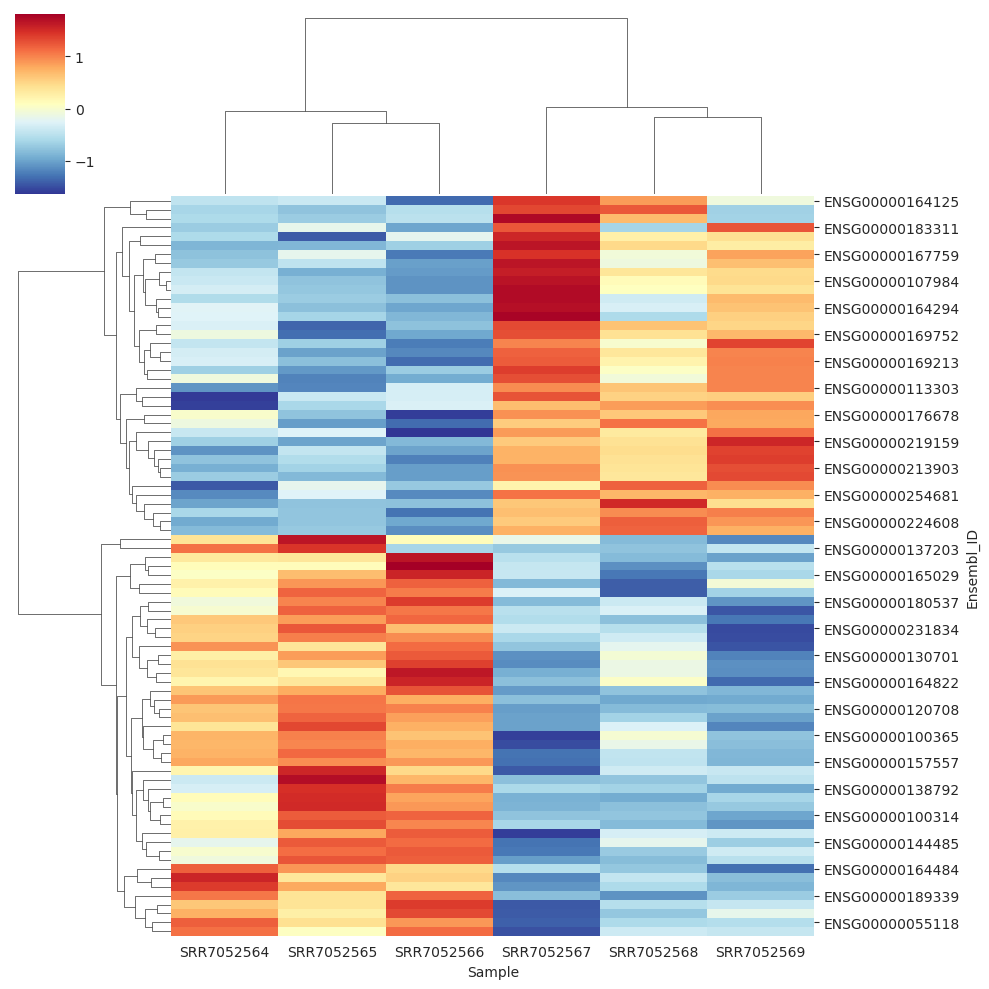

In [10]:
sns.clustermap(grapher, z_score=0, cmap = 'RdYlBu_r')


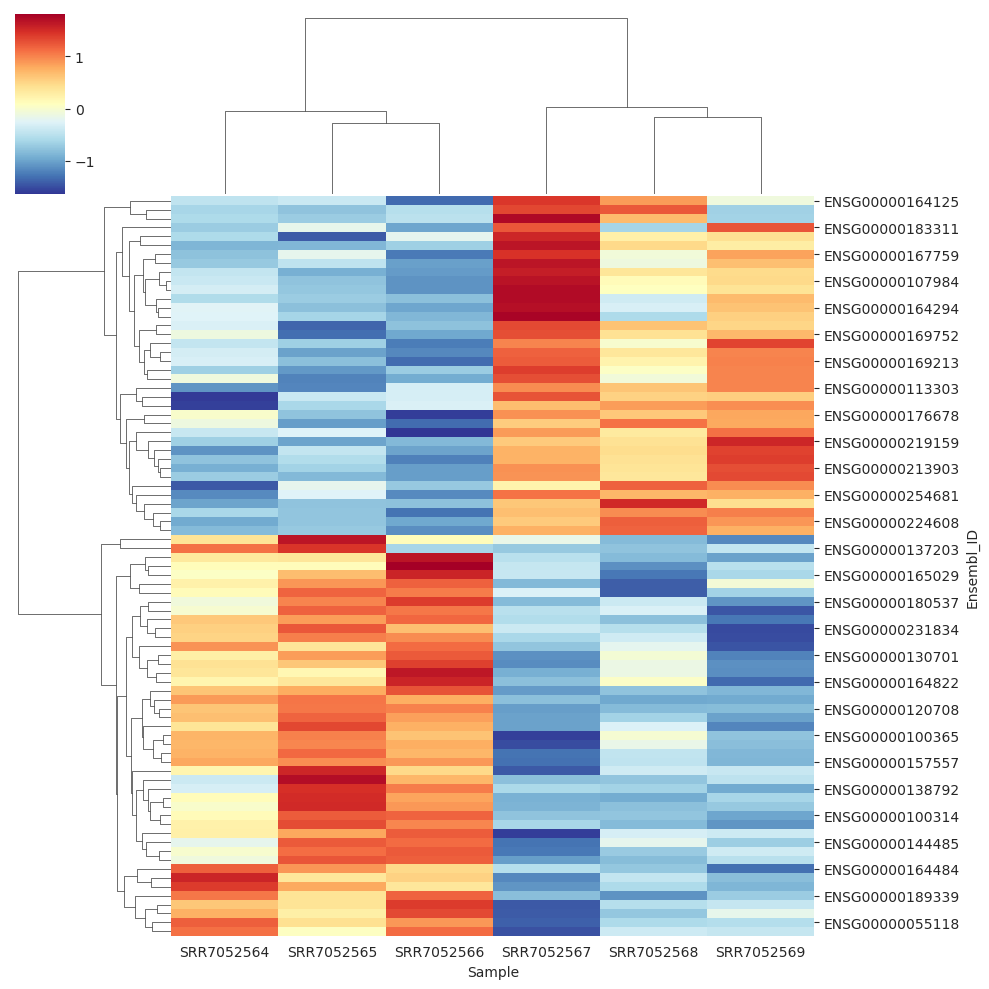

In [13]:
clustergrid = sns.clustermap(grapher, z_score=0, cmap='RdYlBu_r')


In [14]:
clustergrid.savefig("clustermap_quant_4.png", format='png', dpi=300)



In [15]:
clustergrid.savefig("clustermap_quant_4.jpg", format='jpg', dpi=300)



In [16]:
grapher.index = grapher.index.map(mapper.mapper)


In [21]:
type(grapher)

pandas.core.frame.DataFrame

In [22]:
grapher.rename_axis('Gene ID', inplace=True)

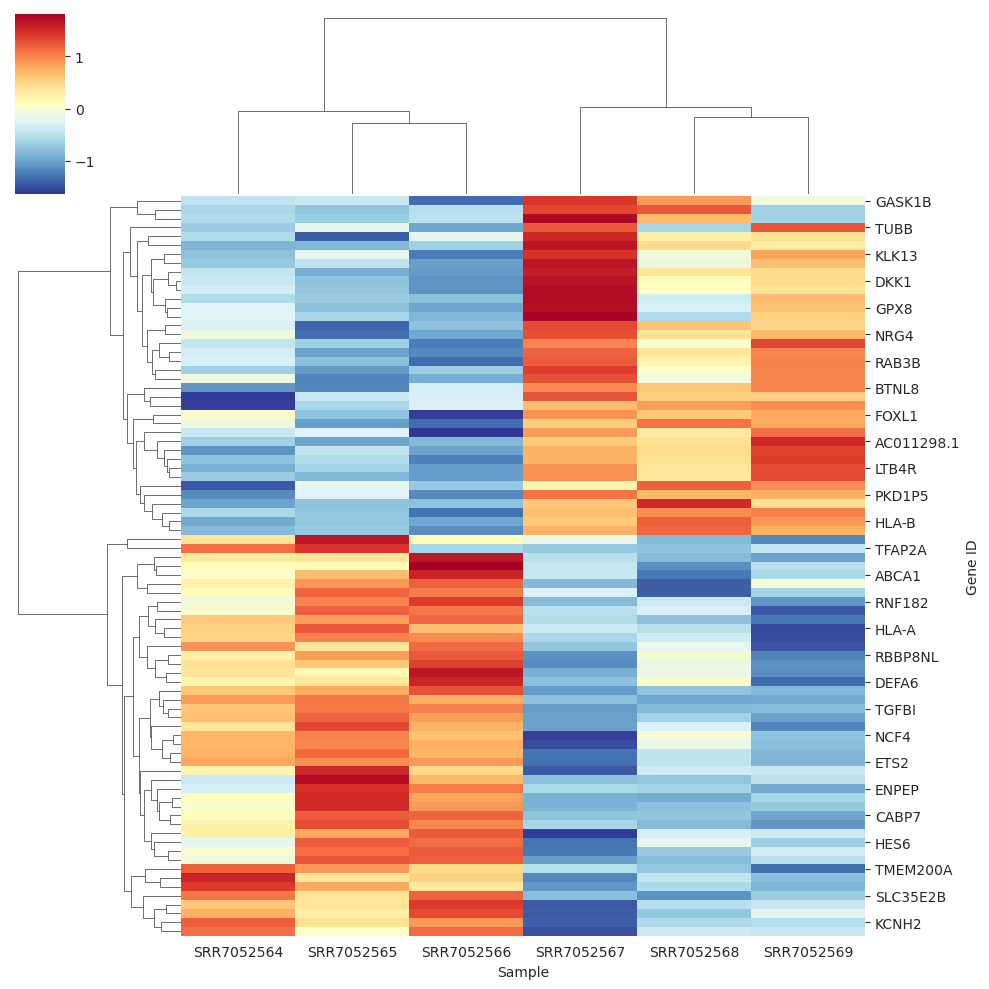

In [23]:
clustergrid_2 = sns.clustermap(grapher, z_score=0, cmap='RdYlBu_r')

In [33]:
clustergrid_2.savefig("clustermap_symbols_quant_4.png", format='png', dpi=300)

In [25]:
clustergrid_2.savefig("clustermap_symbols_quant_4.jpg", format='jpg', dpi=300)

In [26]:
#volcano
from sanbomics.plots import volcano

In [ ]:
volcano(res, symbol='Symbol')


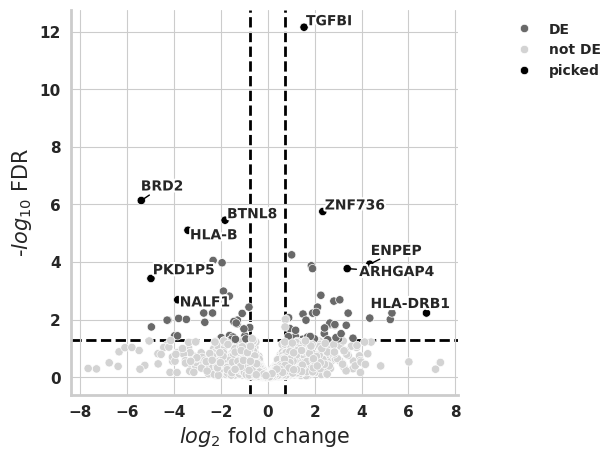

In [32]:
volcano_plot = volcano(res, symbol='Symbol', save= "volcano_plot_quant_4")


In [30]:
volcano_plot.savefig("volcano_plot_quant_4.jpg", format='jpg', dpi=300)

AttributeError: 'NoneType' object has no attribute 'savefig'